<a href="https://colab.research.google.com/github/csabot3/liverAItutorial/blob/main/Lesson1_DataBasics_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 1: Data Basics

Before we begin building radiology AI models with FastAI and Google Colab we need to make sure that we have a grasp of some of the basics, particularly with respect to DICOMs. So, for this first lesson, we won't be doing anything complicated in terms of algorithms/AI, but instead we will focus on looking at and manipulating some of the data that we will be working with in Lesson 2 and beyond.

## Installing packages not in Colab

The Python environment for Colab has several important packages by default, but it is missing some that we want. We will download and install those first. The ! symbol means that we will not be sending code to the Python interpreter but instead send it to the shell for execution. When you see the ! symbol we are no longer writing Python code

In [1]:
#Not in Colab by default, package for working with DICOMs
!pip install pydicom




     |████████████████████████████████| 2.0 MB 8.2 MB/s 


## Downloading Data

We will use the tutorial's GitHub repo to download some sample data to use in this session. One simple way to do this (although not necessarily the most optimal) is to simply clone our tutorial repository and transfer it into Colab

In [2]:
!git clone https://github.com/csabot3/liverAItutorial

Cloning into 'liverAItutorial'...
remote: Enumerating objects: 110, done.
remote: Counting objects: 100% (110/110), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 110 (delta 48), reused 4 (delta 1), pack-reused 0
Receiving objects: 100% (110/110), 124.72 MiB | 24.43 MiB/s, done.
Resolving deltas: 100% (48/48), done.


In [3]:
#Now unzip the files we want from the data directory, the -q flag suppresses some of the output of the unzip command
!unzip -q liverAItutorial/data/ExampleCECT.zip

In [4]:
!unzip -q liverAItutorial/data/ExampleNECT.zip

## Inspecting the Files
Now that you have downloaded and unzipped an example file, you can inspect it on the sidebar and see that it contains several DICOM files. Each DICOM is a single axial contrast enhanced CT slice. 

## Enter Python

With our environment set up and data downloaded, let's now start working with Python a bit. First we will import some libraries that we want to use

In [5]:
import pydicom
import os
from pathlib import Path

import matplotlib.pyplot as plt 

import numpy as np

In [6]:
#Let's see where we are in the file system

os.getcwd()

'/content'

In [7]:
#Now we can get a list of the file names 

pathct='./ExampleNECT/'
ctls=sorted(os.listdir(pathct)) #Sort the list of the files in the directory

In [8]:
#Executing a cell with a variable will show what the variable is storing, we will index to not show too much

ctls[0:10]

['CT000000.dcm',
 'CT000001.dcm',
 'CT000002.dcm',
 'CT000003.dcm',
 'CT000004.dcm',
 'CT000005.dcm',
 'CT000006.dcm',
 'CT000007.dcm',
 'CT000008.dcm',
 'CT000009.dcm']

## DICOM Time

Now let's read a DICOM and see what data the axial CT slice DICOM has in it. This DICOM standard browser may be helpful to review to understand more about DICOMs: https://dicom.innolitics.com/ciods

This DICOM has been de-identified with certain fields edited or removed.

In [9]:
ctexamplefile=pathct+ctls[5]
ctex=pydicom.dcmread(ctexamplefile)
ctex #Look at the file contents, link to spec sheet

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 180
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.12.2.1107.5.8.7.1343.12136.50171517.2.8
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.826.0.1.3680043.8.849
(0002, 0013) Implementation Version Name         SH: 'SST Group'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0012) Instance Creation Date              DA: '20070615'
(0008, 0013) Instance Creation Time              TM: '105514.000000'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID    

What we really want from this DICOM is the image information, though

In [10]:
ctex.pixel_array #Numpy ND array, stored as 16 bit integers

array([[-2000, -2000, -2000, ..., -2000, -2000, -2000],
       [-2000, -2000, -2000, ..., -2000, -2000, -2000],
       [-2000, -2000, -2000, ..., -2000, -2000, -2000],
       ...,
       [-2000, -2000, -2000, ..., -2000, -2000, -2000],
       [-2000, -2000, -2000, ..., -2000, -2000, -2000],
       [-2000, -2000, -2000, ..., -2000, -2000, -2000]], dtype=int16)

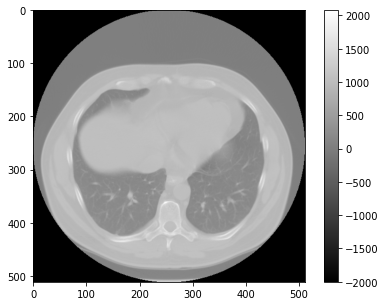

In [11]:
#Let's plot it

fig, ax1 = plt.subplots(figsize=(7, 5), ncols=1)
pos=ax1.imshow(ctex.pixel_array,cmap='gray')
fig.colorbar(pos, ax=ax1)

## Caution!

Now if we are familiar with CT data and Hounsfield units, we might incorrectly assume that the pixel array data we extracted from our DICOM is in Hounsfield units (HU) but this is not necessarily the case and the data will be a linear transform of Hounsfield units. Let's prove this to ourselves

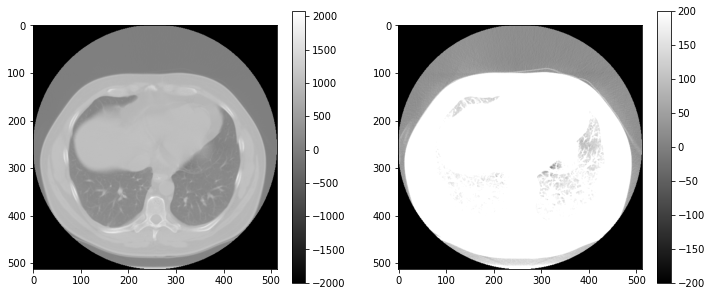

In [12]:
cpimg=np.copy(ctex.pixel_array) #Copy the pixel array
cpimg[cpimg>200]=200 #Windowing the data, while incorrectly trying to assume this is HU
cpimg[cpimg<-200]=-200

fig, (ax1,ax2) = plt.subplots(figsize=(12, 5), ncols=2)
pos=ax1.imshow(ctex.pixel_array,cmap='gray')
fig.colorbar(pos, ax=ax1)
pos2=ax2.imshow(cpimg,cmap='gray')
fig.colorbar(pos2,ax=ax2)

Okay, the windowed image on the right definitely does not make sense for Hounsfield units and our colorbars already show this as well. Let's fix this. The DICOM contains a rescale slope and intercept in the header. We can access this a few ways. We can refer to the print out above in our notebook to see where this data is stored in the DICOM.

In [13]:
ctex[0x0028,0x1052].value #Get the rescale intercept value

'-1024.0'

In [14]:
#Now the slope
ctex[0x0028,0x1053].value

'1.0'

So, we can appropriately rescale the data by multiplying by the rescaling slope (1.0) and adding the intercept (-1024).

However, instead of handling the rescaling manually, we have a built in Pydicom function which can help us
---



---



In [15]:
#We can use this function with the pixel array and DICOM as inputs

huimg=pydicom.pixel_data_handlers.util.apply_modality_lut(ctex.pixel_array,ctex)


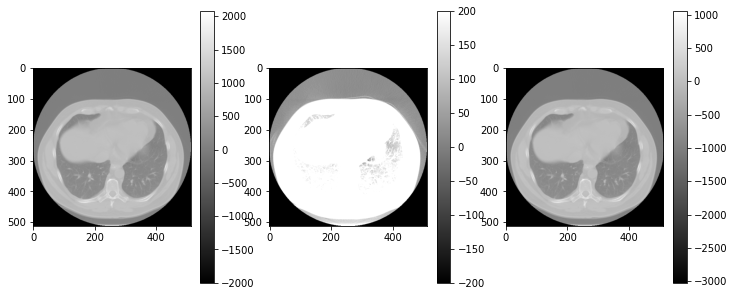

In [16]:
fig, (ax1,ax2,ax3) = plt.subplots(figsize=(12, 5), nrows=1, ncols=3)
pos=ax1.imshow(ctex.pixel_array,cmap='gray')
fig.colorbar(pos, ax=ax1)
pos2=ax2.imshow(cpimg,cmap='gray')
fig.colorbar(pos2,ax=ax2)
pos3=ax3.imshow(huimg,cmap='gray')
fig.colorbar(pos3,ax=ax3)

The right most image now looks like what we would expect for HU values, but it is worth noting that if we inspect the color bar for this image that it is a little bit atypical. The HU values for this image range from -3024 to 1055, as we can check below, but we often expect the minimum HU value for an image to be around -1000 to represent air. So, if we have a 12 bit pixel image, we expect the range to go from -1024 to 3071 typically as we have 4096 possible values for the pixel. However, as we can see when we check the number of bits allocated per pixel below, each pixel has 16 bits as its depth for this DICOM (65,536 possible values). So, we have a wider range of possible values than 12 bits in this case. Even though typically air with a HU of -1000 is treated as a lower bound for HU values, in this case, with a wider range of possible pixel values, the DICOM values have been stored such that air is around -1000 HU in this image and the area outside of the circular region used for reconstruction of the CT data is stored as the more extreme negative HU values around -3000.

In [17]:
np.max(huimg) #Max value in slice

1055.0

In [18]:
np.min(huimg) #Mininum value in slice

-3024.0

In [19]:
ctex['BitsAllocated'] #Check the bits allocated per pixel

(0028, 0100) Bits Allocated                      US: 16

## Converting the Slices to a Volume

In [20]:
#Now let's get the full volume as an array

#First we will see the size of the pixel array in the xy plane

huimg.shape

(512, 512)

In [21]:
len(ctls) #Then number of slices we have

114

In [22]:
vol1=np.zeros((512,512,len(ctls)))

In [23]:
#Let's simplify calling apply_modality_lut

from pydicom.pixel_data_handlers.util import apply_modality_lut

In [24]:
#This will loop through the DICOMs and load them into a 3D array by reading each slice DICOM individually

slicect=0
for x in ctls:
    ctname=pathct+x
    ct_temp=pydicom.dcmread(ctname)
    tempimg=ct_temp.pixel_array
    hutemp=apply_modality_lut(tempimg,ct_temp)
    vol1[:,:,slicect]=hutemp
    slicect=slicect+1

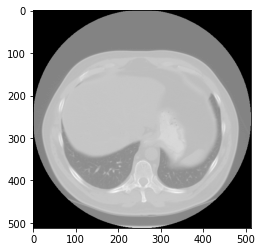

In [25]:
plt.imshow(np.squeeze(vol1[:,:,10]),cmap='gray')

Text(0.5, 1.0, 'Hounsfield Unit Distribution for NECT')

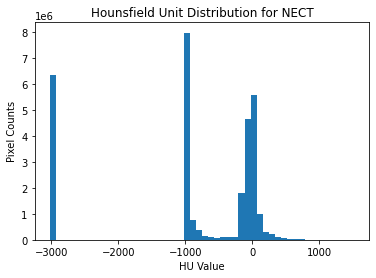

In [26]:
#Let's look at a histogram of the HU values
tb, tn, tp=plt.hist(np.reshape(vol1,-1),50)
plt.xlabel('HU Value')
plt.ylabel('Pixel Counts')
plt.title('Hounsfield Unit Distribution for NECT')

(-1050.0, 1050.0)

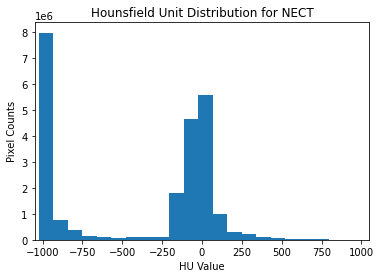

In [28]:
#Look again but ignore the extreme values
tb, tn, tp=plt.hist(np.reshape(vol1,-1),50)
plt.xlabel('HU Value')
plt.ylabel('Pixel Counts')
plt.title('Hounsfield Unit Distribution for NECT')
plt.xlim([-1050,1050])

(-300.0, 500.0)

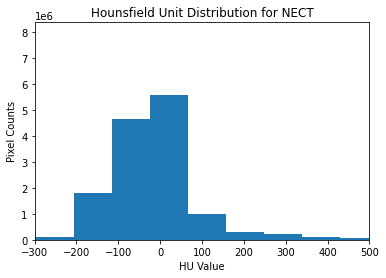

In [42]:
#Adjust the range to focus primarily on fat and soft tissue range values
tb, tn, tp=plt.hist(np.reshape(vol1,-1),50)
plt.xlabel('HU Value')
plt.ylabel('Pixel Counts')
plt.title('Hounsfield Unit Distribution for NECT')
plt.xlim([-300,500])

## Contrast-Enhanced CT

Now let's repeat these steps with a little variation for our contrast-enhanced CT example

In [29]:
#Now load a contrast case - Unfinished portion, adjust to github zip

pathct2='./ExampleCECT/'
ctls2=os.listdir(pathct2)
ctexamplefile2=pathct2+ctls2[5]
ctex2=pydicom.dcmread(ctexamplefile2)

In [30]:
#We can get the size of the slice in different ways, here's a way to get the number of rows
nrows=ctex2[0x0028,0x0010].value
print(nrows)

512


In [31]:
#A more readable option for getting the number of columns
ncols=ctex2['Columns'].value
print(ncols)

512


In [32]:
len(ctls2)

230

In [33]:
vol2=np.zeros((nrows,ncols,len(ctls2)))

slicect=0
for x in ctls2:
    ctname=pathct2+x
    ct_temp=pydicom.dcmread(ctname)
    tempimg=ct_temp.pixel_array
    hutemp=apply_modality_lut(tempimg,ct_temp)
    vol2[:,:,slicect]=hutemp
    slicect=slicect+1

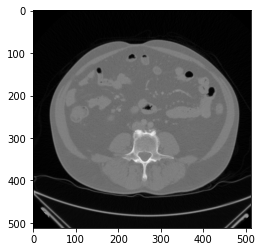

In [34]:
plt.imshow(hutemp,cmap='gray')

In [35]:
np.min(vol2)

-1024.0

In [37]:
np.max(vol2)

3071.0

When we visualize this image, we can now see that unlike the other example, air is not different from values outside a circular reconstruction region, and the minimum values is -1024 HU. 

Text(0.5, 1.0, 'Hounsfield Unit Distribution for CECT')

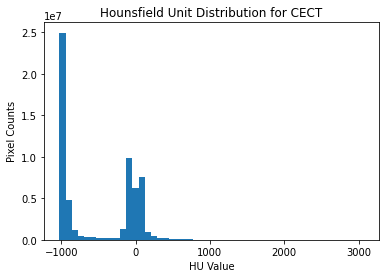

In [36]:
tb, tn, tp=plt.hist(np.reshape(vol2,-1),50)
plt.xlabel('HU Value')
plt.ylabel('Pixel Counts')
plt.title('Hounsfield Unit Distribution for CECT')

(-1050.0, 1050.0)

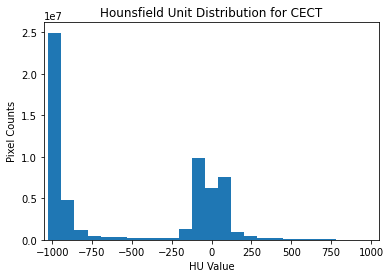

In [39]:
tb, tn, tp=plt.hist(np.reshape(vol2,-1),50)
plt.xlabel('HU Value')
plt.ylabel('Pixel Counts')
plt.title('Hounsfield Unit Distribution for CECT')
plt.xlim([-1050,1050]) #Display again but with a limited x-axis range

(-300.0, 500.0)

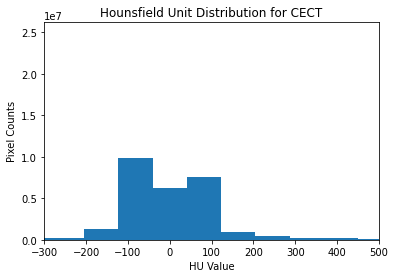

In [43]:
tb, tn, tp=plt.hist(np.reshape(vol2,-1),50)
plt.xlabel('HU Value')
plt.ylabel('Pixel Counts')
plt.title('Hounsfield Unit Distribution for CECT')
plt.xlim([-300,500]) #Display again but with an even more limited x-axis range to focus on fat and soft tissue

## End of Lesson 1

Now that we've looked at some basic data handling. Let's dig into actually doing some AI in Lesson 2 and tackle training U-nets with a public dataset